# neural-retrieval-bert
I've chosen the second project: Neural retrieval model - Document ranking.

# Semantic Search with S-BERT is all you need
I start by following [this](https://medium.com/mlearning-ai/semantic-search-with-s-bert-is-all-you-need-951bc710e160)
tutorial, since it was mentioned in the assignment. Note that most of the code below is copied from this tutorial. We
need to use asymmetric semantic search.

In [1]:
# Start by loading the data
import pandas as pd
df = pd.read_csv("./data/training_data.csv")
df.head()

,Query_number,Query,doc_text,doc_number,index,label
0,2,androgen receptor define,Video Writeups The Ultimate Guide to Sarms Las...,177589,37451,1
1,2,androgen receptor define,Category: SARMSSARMS Reviewed and Explained Dy...,193130,37452,1
2,2,androgen receptor define,The Hormones : Androgens Construction and Prod...,392384,37453,1
3,2,androgen receptor define,"Theriogenology Volume 80, Issue 6, 1 October 2...",15195,37454,1
4,2,androgen receptor define,SARMs: The Controversial Muscle Builders of 20...,269140,37455,1


## Document length

avg. doc_len: 1812.0840857142857


c:\users\arnod\pycharmprojects\neural-retrieval-bert\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


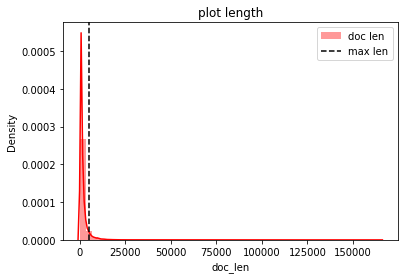

In [2]:
# See how long the text information is
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df['doc_len'] = df['doc_text'].apply(lambda words: len(str(words).split()))
print(f"avg. doc_len: {df['doc_len'].mean()}")
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='r', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

Our document length is similar to the one described in the tutorial, with the exception that we have larger outliers.
We'll also slice everything off for a length greater than 512.
## Model
We'll also use "sentence-transformers/msmarco-distilbert-base-dot-prod-v3”, since we're dealing with assymmetric search and trying to retrieve long passages.

In [3]:
import os
from sentence_transformers import SentenceTransformer, models
# First described model in the tutorial
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
# Later described model
# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sentence-transformers/msmarco-distilbert-base-dot-prod-v3')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os

train_examples = []
with open('../input/user-query-data/generated_queries_all (1).tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=8)
# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)

In [ ]:
#Tune the model
num_epochs = 3
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True)

os.makedirs('search', exist_ok=True)
model.save('search/search-model')

In [4]:
import faiss
encoded_data = model.encode(df.doc_text.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'movie_plot.index')

ModuleNotFoundError: No module named 'faiss'

## Search

In [ ]:
import time

def fetch_movie_info(dataframe_idx):
    """
    dataframe_idx: integer -> index value extracted from movie_plot.index which can be used to map back to our
    data-frame to fetch additional information.
    """
    info = df.iloc[dataframe_idx]
    meta_dict = dict()
    meta_dict['doc_number'] = info['doc_number']
    meta_dict['doc_text'] = info['doc_text'][:500]
    return meta_dict

def search(query, top_k, index, model):
    """
    query: string -> user typed query
    top_k: integer -> number of results to be returned
    index: faiss_index -> index to query the for results
    model: sbert -> model to encode the user-query
    """
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [ ]:
from pprint import pprint

query="androgen receptor define"
results=search(query, top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

The tutorial continues [here](https://medium.com/mlearning-ai/search-rank-and-recommendations-35cc717772cb).

# Fine-tuning pre-trained transformer models for sentence entailment
This are some additional notes by following [this](https://towardsdatascience.com/fine-tuning-pre-trained-transformer-models-for-sentence-entailment-d87caf9ec9db) tutorial. Note that most of the code below is copied from there.
## Dataloader

In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'entailment': 0, 'contradiction': 1, 'neutral': 2}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['sentence1'].to_list()
    hypothesis_list = df['sentence2'].to_list()
    label_list = df['gold_label'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])

    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

mnli_dataset = MNLIDataBert(train_df, val_df)

In [ ]:
from transformers import BertForSequenceClassification, AdamW

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) # We have only 2 labels: Relevant or irrelevant
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, correct_bias=False)

In [ ]:
def multi_acc(y_pred, y_test):
  acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
  return acc

import time

EPOCHS = 5

def train(model, train_loader, val_loader, optimizer):
  total_step = len(train_loader)

  for epoch in range(EPOCHS):
    start = time.time()
    model.train()
    total_train_loss = 0
    total_train_acc  = 0
    for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
      optimizer.zero_grad()
      pair_token_ids = pair_token_ids.to(device)
      mask_ids = mask_ids.to(device)
      seg_ids = seg_ids.to(device)
      labels = y.to(device)

      loss, prediction = model(pair_token_ids,
                             token_type_ids=seg_ids,
                             attention_mask=mask_ids,
                             labels=labels).values()

      acc = multi_acc(prediction, labels)

      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()
      total_train_acc  += acc.item()

    train_acc  = total_train_acc/len(train_loader)
    train_loss = total_train_loss/len(train_loader)
    model.eval()
    total_val_acc  = 0
    total_val_loss = 0
    with torch.no_grad():
      for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
        optimizer.zero_grad()
        pair_token_ids = pair_token_ids.to(device)
        mask_ids = mask_ids.to(device)
        seg_ids = seg_ids.to(device)
        labels = y.to(device)

        loss, prediction = model(pair_token_ids,
                             token_type_ids=seg_ids,
                             attention_mask=mask_ids,
                             labels=labels).values()

        acc = multi_acc(prediction, labels)

        total_val_loss += loss.item()
        total_val_acc  += acc.item()

    val_acc  = total_val_acc/len(val_loader)
    val_loss = total_val_loss/len(val_loader)
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)

    print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)) 